## Conterfactual methods

In [1]:
import time
import pandas as pd
import numpy as np

from utils import read_diabetes_dataset

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

from cfmining.algorithms import MAPOCAM, BruteForce, Greedy
from cfmining.criteria import PercentileCalculator, PercentileCriterion, PercentileChangesCriterion, NonDomCriterion
from cfmining.predictors import MonotoneClassifier
from cfmining.visualization import buildTable, PlotCounterfactuals
from cfmining.mip_builder import RecourseBuilder
from cfmining.action_set import ActionSet



Bad key "text.kerning_factor" on line 4 in
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Dataset

In [2]:
# columns = ['gender', 'age', 'time_in_hospital', 'diag_1', 'diag_2', 'diag_3', 'metformin',
#            'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin', 'number_inpatient', 'discharge_11']
# columns = ['gender', 'age', 'time_in_hospital', 'diag_1', 'diag_2', 'diag_3', 'metformin',
#            'number_inpatient', 'discharge_11']
columns = ['number_inpatient', 'number_outpatient','number_emergency', 'num_medications', 'discharge_11', 'weight', 'time_in_hospital', 'age', 'number_diagnoses']



In [3]:
X, y = read_diabetes_dataset(binary=True)
X = X.sample(2500)[columns]
y = y[X.index]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101)


In [4]:
clf_logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
grid = GridSearchCV(
    clf_logreg, param_grid={'C': np.logspace(-12, 12, num=25)},
    cv=5,
    scoring='roc_auc',
)

grid.fit(X_train, y_train)
clf_logreg = grid.best_estimator_


In [5]:
print('AUC performance:', roc_auc_score(y_test, clf_logreg.predict_proba(X_test)[:,1]))

AUC performance: 0.6458395344683892


In [6]:
prob = 0.53
clf_logreg_ = MonotoneClassifier(clf_logreg, X_train, y_train, threshold=prob)
coefficients = clf_logreg.coef_[0]
intercept = clf_logreg.intercept_[0]

In [7]:
X.head()

,number_inpatient,number_outpatient,number_emergency,num_medications,discharge_11,weight,time_in_hospital,age,number_diagnoses
50137,1,0,0,6,0,0.0,2,85,4
16923,0,0,0,21,0,0.0,7,55,9
17927,0,0,0,20,0,0.0,3,55,7
31214,0,0,0,16,0,0.0,2,55,7
15971,0,0,0,33,0,0.0,8,65,9


In [8]:
action_set = ActionSet(X = X)
action_set.embed_linear_clf(coefficients=coefficients)

for feat in action_set:
    feat.step_type ="relative"
    feat.step_size = 0.1
    feat.update_grid()
    
action_set['age'].mutable = False


In [9]:
pd_coef = pd.Series(coefficients, index=X.columns).to_frame('Coefficients')
pd_coef

,Coefficients
number_inpatient,0.507399
number_outpatient,0.180560
number_emergency,0.137734
num_medications,-0.001436
discharge_11,-32.113717
weight,0.007129
time_in_hospital,0.046150
age,0.007566
number_diagnoses,0.083054


In [10]:
scores = pd.Series(clf_logreg.predict_proba(X)[:, 1])
denied_individuals = scores.loc[lambda s: (s < prob)].index

In [11]:
choice = 162
choice = choice if choice in denied_individuals else np.random.choice(denied_individuals)
print('Choice:', choice)
individual = X.iloc[choice].values

Choice: 162


In [12]:
# individual

In [13]:
percCalc = PercentileCalculator(action_set=action_set)
percCriteria = PercentileCriterion(individual, percCalc)
percChCriteria = PercentileChangesCriterion(individual, percCalc)


In [14]:
p = prob
start = time.perf_counter()
rb = RecourseBuilder(
    optimizer="cplex",
    coefficients=coefficients,
    intercept=intercept - (np.log(p / (1. - p))),
    action_set=action_set,
    x=individual
)

build_info, indices = rb._get_mip_build_info()
output_1 = rb.fit()
print('Elapsed time:', time.perf_counter()-start)


Elapsed time: 0.013142623000021558


In [15]:
print('Number of actions', sum(output_1['actions']!=0))
(pd.Series(output_1['actions']+individual, index=X.columns).iloc[output_1['actions']!=0].to_frame('Actions')).replace(0,'-')

Number of actions 2


,Actions
number_emergency,2.0
weight,64.0


In [16]:
en_nd_feat = MAPOCAM(action_set, individual, clf_logreg_, max_changes=3)
start = time.perf_counter()
en_nd_feat.fit()
print('Elapsed time:', time.perf_counter()-start)


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/b

Elapsed time: 0.7018661849997443


/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/home/texs/anaconda3/envs/rapidsml/lib/python3.7/site-packages/sklearn/b

In [17]:
names = action_set.df['name'].values
overview_clean = buildTable(en_nd_feat, individual, percCriteria, names, include_original=False, include_cost=False)
overview_full = buildTable(en_nd_feat, individual, percCriteria, names, include_original=True, include_cost=True)

In [18]:
overview_full.replace(np.nan, '-')
# overview_full


,Orig,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C137,C138,C139,C140,C141,C142,C143,C144,C145,C146
number_inpatient,0.0,-,-,-,1.0,1.0,1.0,1.0,1.0,-,...,-,-,-,-,-,-,-,-,-,-
number_outpatient,0.0,-,1.0,1.0,-,-,-,1.0,1.0,2.0,...,1.0,-,-,-,-,-,-,-,-,-
number_emergency,0.0,2.0,2.0,1.0,2.0,1.0,-,-,1.0,2.0,...,-,-,-,-,1.0,-,1.0,2.0,-,1.0
num_medications,11.0,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
discharge_11,0.0,-,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
weight,0.0,64.0,40.0,64.0,-,16.0,32.0,8.0,-,16.0,...,8.0,24.0,16.0,24.0,-,32.0,16.0,-,-,-
time_in_hospital,2.0,-,-,-,-,-,-,-,-,-,...,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0,13.0
age,75.0,-,-,-,-,-,-,-,-,-,...,-,-,95.0,87.0,87.0,-,-,-,87.0,-
number_diagnoses,7.0,-,-,-,-,-,-,-,-,-,...,-,8.0,-,-,-,-,-,-,9.0,8.0
Cost,-,-,-,-,0.087621,0.087621,0.087621,0.087621,0.087621,-,...,-,-,-,-,-,-,-,-,-,-


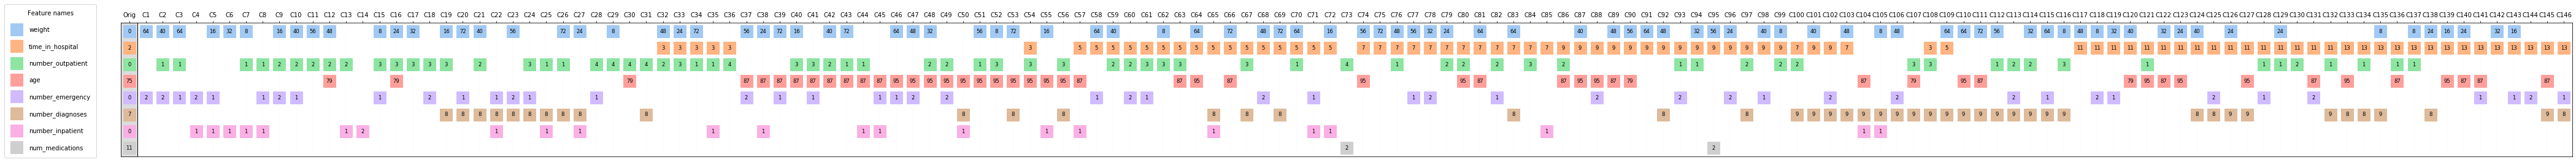

In [19]:
pltW = PlotCounterfactuals(overview_clean.iloc[:,:], individual)
pltW.show(None, bbox_to_anchor=(-0.01, -0.01))
# pltW.show()
# pltW.plot(aspect=1)